In [ ]:
import requests
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import h5py
import gizmo_analysis as gizmo 
import halo_analysis as halo
import utilities as ut
import glob
from astropy import units as u
from utils import rotate

ModuleNotFoundError: No module named 'utils'

In [2]:
from ray_trace import gas_in_halo, get_box_crossings_z, ray_trace

In [4]:
def gas_in_halo(sim_name, region = 'all', assign_hosts = 'track', assign_hosts_rotation = True):
    sim_dir = f'/pool001/zimi/analysis/FIRE/{sim_name}/'

    # read gas particles at z=0, store as python dictionary
    part = gizmo.io.Read.read_snapshots(['gas'], 'redshift', 0, sim_dir, assign_hosts=assign_hosts, assign_hosts_rotation=assign_hosts_rotation)
    hal = halo.io.IO.read_catalogs('redshift', 0, sim_dir, species='gas')


    gas = part['gas']
    positions = gas['position']
    x = positions[:,0]
    y = positions[:,1]
    z = positions[:,2]

    dist = gas.prop('host.distance.principal')
    dist_x = dist[:,0]
    dist_y = dist[:,1]
    dist_z = dist[:,2]
    dist_tot = gas.prop('host.distance.total')

    dens = gas['density']
    electron_abundance = gas['electron.fraction']
    ne = electron_abundance*gas.prop('number.density') # electron number density, units:cm^-3
    binsize = gas['size']
    temp = gas['temperature']
    metallicity = gas['massfraction'][:,0] # metals mass fraction
    helium = gas['massfraction'][:,1] # metals mass fraction

    # make pandas dataframe
    data = {'x': x,
            'y': y,
            'z': z,
            'dist_x': dist_x,
            'dist_y':dist_y,
            'dist_z': dist_z,
            'dist_tot': dist_tot,
            'density': dens,
            'electron_abundance': electron_abundance,
            'n_e': ne,
            'bin_size': binsize,
            'temp': temp,
            'metallicity': metallicity,
            'helium': helium}

    gas_df = pd.DataFrame(data)

    host_index = hal['host.index'][0]
    host_radius = hal['radius'][host_index]

    if region == 'all':
        mask = (gas_df['dist_tot'] <= host_radius)
    elif region == 'cgm':
        mask = (gas_df['dist_tot'] <= host_radius) & (gas_df['dist_tot'] >= host_radius*0.15)
    
    halo_gas = gas_df[mask]

    return halo_gas, host_radius



In [3]:
def rotate(coord, theta, phi):
    """
    output:
    new (dist_x, dist_y, dist_z) after rotation

    """

    # rotate theta around x axis
    r_x = [[1, 0, 0], 
           [0, np.cos(theta), -np.sin(theta)],
           [0, np.sin(theta), np.cos(theta)]]

    # rotate phi around z axis
    r_z = [[np.cos(phi), -np.sin(phi), 0], 
           [np.sin(phi), np.cos(theta), -np.sin(theta)],
           [0, np.sin(theta), np.cos(theta)]]
    
    #rotate each 
    temp = np.matmul(r_x, coord)
    result = np.matmul(r_z, temp)

    return result

    

In [ ]:
def get_box_crossings_z(halo_gas, ray_location):
    """
    Given an (x,y) location, finds the intersecting gas particles along the z-axis
    (perpendicular to the face of galactic plane)

    Parameters
    --------
    halo_gas: Dataframe
        properties of gas contained in halo
    """

    ray_location = np.asarray(ray_location)

    if not(ray_location.shape == (2,)):
        raise ValueError('location must be (2,) array')
    
    binsizes = halo_gas['bin_size']
    max_size = np.max(binsizes)
    
    # calculate distance from particle center to ray location
    line = halo_gas[['dist_x', 'dist_y']] - ray_location

    # particles that are insize a max_size*max_size box outside ray location
    # inside_ind = (line['dist_x'] < max_size and line['dist_y'] < max_size)

    dist_sq = line['dist_x']**2+line['dist_y']**2
    halo_gas['dist_ray_sq'] = dist_sq

    mask = (dist_sq < binsizes**2)
    gas_intersect = halo_gas[mask]

    return gas_intersect

def ray_trace(halo_gas, ray_location):

    gas_intersect = get_box_crossings_z(halo_gas, ray_location)

    # get chord length 
    # chord_len should have units of kpc
    chord_len = 2*np.sqrt(gas_intersect['bin_size']**2-gas_intersect['dist_ray_sq'])

    # get DM
    dm = np.sum(chord_len*gas_intersect['n_e'])* u.kpc/u.cm**-2

    return dm.to(u.pc/u.cm**-2)

In [4]:
sim_name = 'm12f_res7100'

In [5]:
halo_gas, host_radius = gas_in_halo(sim_name, 'all')


# in utilities.simulation.Snapshot():
* reading:  pool001/zimi/analysis/FIRE/m12f_res7100/snapshot_times.txt

* input redshift = 0:  using snapshot index = 600, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  pool001/zimi/analysis/FIRE/m12f_res7100/output/snapshot_600.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 96239056 particles
    dark2     (id = 2): 7591203 particles
    gas       (id = 0): 80307825 particles
    star      (id = 4): 16066489 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['gas']

* reading particles from:
    snapshot_600.0.hdf5
    snapshot_600.1.hdf5
    snapshot_600.2.hdf5
    snapshot_600.3.hdf5

* reading cosmological parameters from:  pool001/zimi/analysis/FIRE/m12f_res7100/initial_condition/ic_agora_m12f.conf

* checking sanity of particle properties
! warning: gas id.child [min, max] = [0.000, 4.281e9]
! warning: gas mass [min, med, max] = [7067.277

In [10]:
coord = halo_gas[['dist_x', 'dist_y', 'dist_z']]

In [12]:
np.matmul(coord, [1,2,3])

0           135.585940
1           136.964686
2           135.813889
3           136.503494
4           132.785365
               ...    
80276983    287.054362
80276984    284.257270
80276985    275.732956
80276986    281.316221
80276987    278.788732
Length: 15743026, dtype: float64

In [5]:
arr = [[0.1,2,3,4,9], [3,6,8,9,10]]
bins = [0.5, 4.7, 9]
np.digitize(arr, bins)

array([[0, 1, 1, 1, 3],
       [1, 2, 2, 3, 3]])

In [33]:
print(np.min(halo_gas['bin_size']))
print(np.max(halo_gas['bin_size']))

0.002516951
7.556431


Text(0.5, 1.0, 'm12f (including galactic disk)')

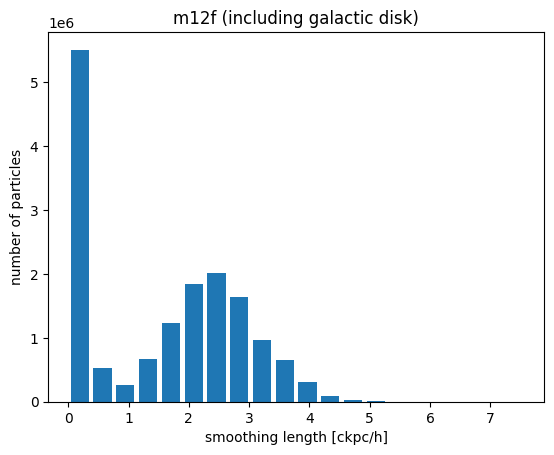

In [34]:
plt.hist(halo_gas['bin_size'], bins = 20, rwidth = 0.8)
plt.xlabel('smoothing length [ckpc/h]')
plt.ylabel('number of particles')
plt.title('m12f (including galactic disk)')

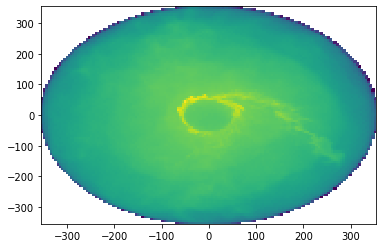

In [13]:
h = plt.hist2d(halo_gas['dist_x'],halo_gas['dist_y'], bins=[150,100], norm=matplotlib.colors.LogNorm())

In [9]:
ray_trace(halo_gas,(0,0))

<Quantity 46.27847374 cm2 pc>

In [ ]:
dms = []
x=[]
y=[]

for i in range(-1, 2):
    # dms.append([])
    for j in range(-1, 2):
        dm = ray_trace(halo_gas, [i,j]).value
        dms.append(dm)
        x.append(i)
        y.append(j)

In [19]:
def plot_dms(sim_name, x, y, dms, bins, norm):
    fig, ax = plt.subplots()
    h = ax.hist2d(x, y, weights = dms, bins = bins, norm = norm)
    ax.set_xlabel('$\Delta x$ [ckpc/h]')
    ax.set_ylabel('$\Delta y$ [ckpc/h]')
    ax.axis('equal')
    ax.set_title('m12f')
    fig.colorbar(h[3], label = 'DM [pc/$cm^3$]')

    fig.savefig(f'outputs/{sim_name}/dm_15kpc', dpi = 200)

    plt.show()

In [4]:
# loading data from file and plotting

output_files = sorted(glob.glob('outputs/m12f_res7100/dms_355kpc_cgm_*.npy'))
arrays = []
for f in output_files:
    arrays.append(np.load(f))
dms = np.concatenate(arrays)


Text(0.5, 1.0, 'm12f (CGM only)')

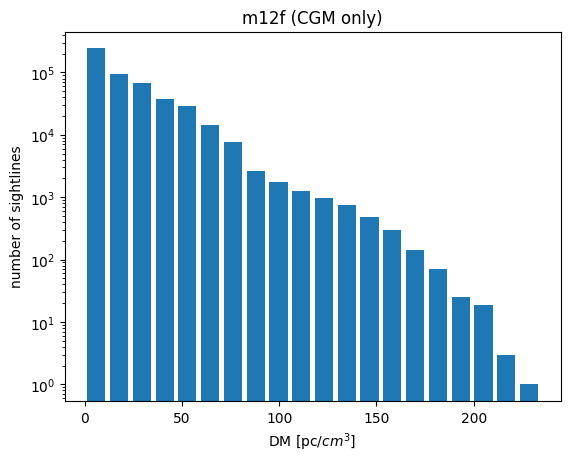

In [3]:
plt.hist(dms, bins = 20, rwidth = 0.8, log = True)
plt.xlabel('DM [pc/$cm^3$]')
plt.ylabel('number of sightlines')
plt.title('m12f (CGM only)')


In [5]:
x = np.repeat(np.linspace(-355, 355, 711), 711)
y = np.tile(np.linspace(-355,355, 711), 711)


In [18]:
dist = np.linalg.norm([x,y], axis = 0)

In [17]:
mean = scipy.stats.binned_statistic(dist, dms, statistic = 'mean', bins = 20)
std = scipy.stats.binned_statistic(dist, dms, statistic = 'std', bins = 20).statistic

AttributeError: The number of `values` elements must match the length of each `sample` dimension.

In [8]:
theoretical = np.load('theoretical_DM_halo.npz')

Text(0.5, 1.0, 'm12f (CGM only)')

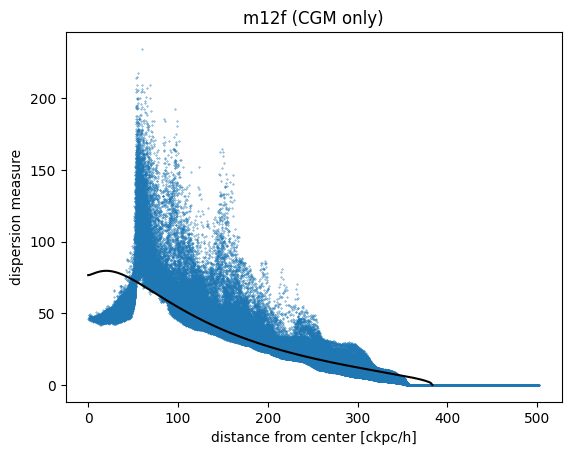

In [9]:
fig, ax = plt.subplots()
ax.scatter(dist, dms, s = 0.1)
ax.plot(theoretical['radii']/0.7, theoretical['dm'], c = 'k')
# ax.axvline(x , color = 'b', label = 'axvline - full height')
ax.set_xlabel('distance from center [ckpc/h]')
ax.set_ylabel('dispersion measure')
ax.set_title('m12f (CGM only)')


In [ ]:
def power(x, a, b, c):
    return a + b * x ** c

initial_guess = [1e4, 1e4, 0.5]

scipy.optimize.curve_fit(power, (mean.bin_edges[1:]+ mean.bin_edges[:-1])/2, mean.statistic, sigma = std, p0 = initial_guess)

/home/zimi/frb_scattering/new_venv/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:968: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/tmp/ipykernel_32300/2837781040.py:6: OptimizeWarning: Covariance of the parameters could not be estimated
  scipy.optimize.curve_fit(power, (mean.bin_edges[1:]+ mean.bin_edges[:-1])/2, mean.statistic, sigma = std, p0 = initial_guess)


(array([1.e+04, 1.e+04, 5.e-01]),
 array([[inf, inf, inf],
        [inf, inf, inf],
        [inf, inf, inf]]))

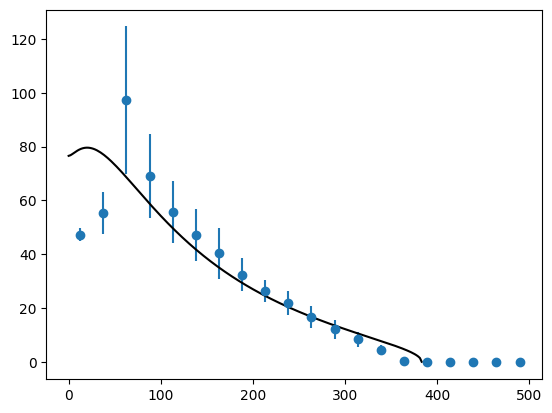

In [10]:
plt.errorbar((mean.bin_edges[1:]+ mean.bin_edges[:-1])/2, mean.statistic, yerr = std, fmt = 'o')
plt.plot(theoretical['radii']/0.7, theoretical['dm'], c = 'k')